In [1]:
import torch

print("PyTorch 버전:", torch.__version__)
print("GPU 사용 가능 여부:", torch.cuda.is_available())


PyTorch 버전: 2.6.0+cpu
GPU 사용 가능 여부: False


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np


In [3]:
file_path = 'C://Users//Chick//AI-class//diabetes.csv'  
df = pd.read_csv(file_path)

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# 데이터와 타겟 분리
X = df.drop(columns=['Outcome'], axis=1).values
y = df['Outcome']

In [6]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 


((614, 8), (154, 8), (614,), (154,))

In [8]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.int64)

In [9]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

In [11]:
# 모델 정의
class diabetesEvaluationDense(nn.Module):
    def __init__(self):
        super(diabetesEvaluationDense, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # 4 classes in the dataset
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = diabetesEvaluationDense()


In [12]:
# 손실 함수 및 최적화 기법 정의
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


In [13]:
# 모델 학습
# 손실과 정확도 저장용 리스트
train_losses = []
test_accuracies = []

# 학습 루프
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()

        outputs = model(inputs).squeeze()  # 출력 shape 맞추기
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_dataloader))

    # 평가
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs).squeeze()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).int()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6971, Accuracy: 68.83%
Epoch 2/20, Loss: 0.6875, Accuracy: 68.18%
Epoch 3/20, Loss: 0.6806, Accuracy: 68.83%
Epoch 4/20, Loss: 0.6746, Accuracy: 69.48%
Epoch 5/20, Loss: 0.6686, Accuracy: 69.48%
Epoch 6/20, Loss: 0.6613, Accuracy: 69.48%
Epoch 7/20, Loss: 0.6574, Accuracy: 69.48%
Epoch 8/20, Loss: 0.6536, Accuracy: 69.48%
Epoch 9/20, Loss: 0.6434, Accuracy: 69.48%
Epoch 10/20, Loss: 0.6422, Accuracy: 69.48%
Epoch 11/20, Loss: 0.6411, Accuracy: 69.48%
Epoch 12/20, Loss: 0.6340, Accuracy: 69.48%
Epoch 13/20, Loss: 0.6281, Accuracy: 69.48%
Epoch 14/20, Loss: 0.6234, Accuracy: 69.48%
Epoch 15/20, Loss: 0.6184, Accuracy: 69.48%
Epoch 16/20, Loss: 0.6147, Accuracy: 70.13%
Epoch 17/20, Loss: 0.6103, Accuracy: 71.43%
Epoch 18/20, Loss: 0.6020, Accuracy: 72.08%
Epoch 19/20, Loss: 0.5962, Accuracy: 73.38%
Epoch 20/20, Loss: 0.5897, Accuracy: 74.03%
Training complete.


In [14]:
# 모델 평가
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Evaluation
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs).squeeze()
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).int()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)

# Calculate specificity (for binary classification)
tn = conf_matrix[0][0]
fp = conf_matrix[0][1]
specificity = tn / (tn + fp)

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')

Confusion Matrix:
[[105   2]
 [ 38   9]]
F1 Score: 0.31
Precision: 0.82
Recall: 0.19
Specificity: 0.98


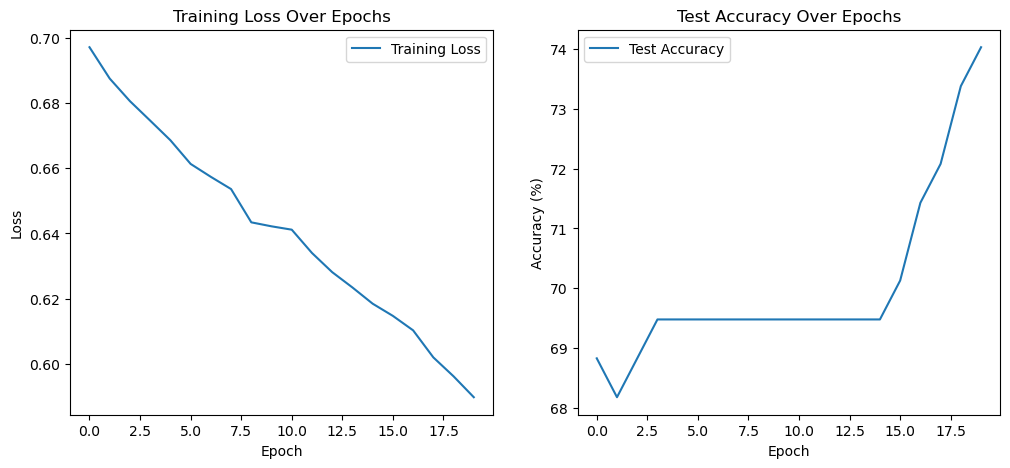

In [15]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()
